In [1]:
# import Python libraries
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import sympy as sym
from sympy.plotting import plot
import pandas as pd
from IPython.display import display
from IPython.core.display import Math

In [2]:
# time elbow_flexion BIClong BICshort BRA
r_ef = np.loadtxt('./../data/r_elbowflexors.mot', skiprows=7)
f_ef = np.loadtxt('./../data/f_elbowflexors.mot', skiprows=7)

In [3]:
m_ef = r_ef*1
m_ef[:, 2:] = r_ef[:, 2:]*f_ef[:, 2:]

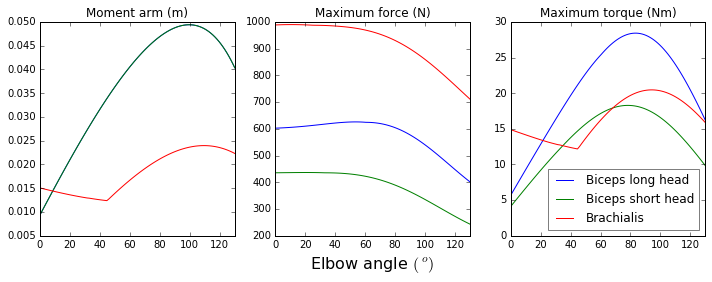

In [4]:
labels = ['Biceps long head', 'Biceps short head', 'Brachialis']
fig, ax = plt.subplots(nrows=1, ncols=3, sharex=True, figsize=(10, 4))
ax[0].plot(r_ef[:, 1], r_ef[:, 2:])
#ax[0].set_xlabel('Elbow angle $(\,^o)$')
ax[0].set_title('Moment arm (m)')
ax[1].plot(f_ef[:, 1], f_ef[:, 2:])
ax[1].set_xlabel('Elbow angle $(\,^o)$', fontsize=16)
ax[1].set_title('Maximum force (N)')
ax[2].plot(m_ef[:, 1], m_ef[:, 2:])
#ax[2].set_xlabel('Elbow angle $(\,^o)$')
ax[2].set_title('Maximum torque (Nm)')
ax[2].legend(labels, loc='best', framealpha=.5)
ax[2].set_xlim(np.min(r_ef[:, 1]), np.max(r_ef[:, 1]))
plt.tight_layout()
plt.show()

In [5]:
a_ef = np.array([624.3, 435.56, 987.26])/50  # 50 N/cm2
print(a_ef)

[ 12.486    8.7112  19.7452]


In [6]:
from scipy.optimize import minimize

In [7]:
def cf_f1(x):
    """Cost function: sum of forces."""  
    return x[0] + x[1] + x[2]

def cf_f2(x):
    """Cost function: sum of forces squared."""
    return x[0]**2 + x[1]**2 + x[2]**2

def cf_fpcsa2(x, a):
    """Cost function: sum of squared muscle stresses."""
    return (x[0]/a[0])**2 + (x[1]/a[1])**2 + (x[2]/a[2])**2

def cf_fmmax3(x, m):
    """Cost function: sum of cubic forces normalized by moments."""
    return (x[0]/m[0])**3 + (x[1]/m[1])**3 + (x[2]/m[2])**3

In [8]:
def cf_f1d(x):
    """Derivative of cost function: sum of forces."""
    dfdx0 = 1
    dfdx1 = 1
    dfdx2 = 1
    return np.array([dfdx0, dfdx1, dfdx2])

def cf_f2d(x):
    """Derivative of cost function: sum of forces squared."""
    dfdx0 = 2*x[0]
    dfdx1 = 2*x[1]
    dfdx2 = 2*x[2]
    return np.array([dfdx0, dfdx1, dfdx2])

def cf_fpcsa2d(x, a):
    """Derivative of cost function: sum of squared muscle stresses."""
    dfdx0 = 2*x[0]/a[0]**2
    dfdx1 = 2*x[1]/a[1]**2
    dfdx2 = 2*x[2]/a[2]**2
    return np.array([dfdx0, dfdx1, dfdx2])

def cf_fmmax3d(x, m):
    """Derivative of cost function: sum of cubic forces normalized by moments."""
    dfdx0 = 3*x[0]**2/m[0]**3
    dfdx1 = 3*x[1]**2/m[1]**3
    dfdx2 = 3*x[2]**2/m[2]**3
    return np.array([dfdx0, dfdx1, dfdx2])

In [27]:
M = 20  # desired torque at the elbow
iang = 69  # which will give the closest value to 90 degrees
r  = r_ef[iang, 2:]
f0 = f_ef[iang, 2:]
a  = a_ef
m  = m_ef[iang, 2:]
x0 = f_ef[iang, 2:]/10  # far from the correct answer for the sum of torques
print('M =', M)
print('x0 =', x0)
print('r * x0 =', np.sum(r*x0))

M = 20
x0 = [ 57.51311369  36.29974032  89.6470056 ]
r * x0 = 6.62200444607


In [28]:
bnds = ((0, f0[0]), (0, f0[1]), (0, f0[2]))

In [29]:
# use this in combination with the parameter bounds:
cons = ({'type': 'eq',
         'fun' : lambda x, r, f0, M: np.array([r[0]*x[0] + r[1]*x[1] + r[2]*x[2] - M]), 
         'jac' : lambda x, r, f0, M: np.array([r[0], r[1], r[2]]), 'args': (r, f0, M)})

In [30]:
# to enter everything as constraints:
cons = ({'type': 'eq',
         'fun' : lambda x, r, f0, M: np.array([r[0]*x[0] + r[1]*x[1] + r[2]*x[2] - M]), 
         'jac' : lambda x, r, f0, M: np.array([r[0], r[1], r[2]]), 'args': (r, f0, M)},
        {'type': 'ineq', 'fun' : lambda x, r, f0, M: f0[0]-x[0],
         'jac' : lambda x, r, f0, M: np.array([-1, 0, 0]), 'args': (r, f0, M)},
        {'type': 'ineq', 'fun' : lambda x, r, f0, M: f0[1]-x[1],
         'jac' : lambda x, r, f0, M: np.array([0, -1, 0]), 'args': (r, f0, M)},
        {'type': 'ineq', 'fun' : lambda x, r, f0, M: f0[2]-x[2],
         'jac' : lambda x, r, f0, M: np.array([0, 0, -1]), 'args': (r, f0, M)},
        {'type': 'ineq', 'fun' : lambda x, r, f0, M: x[0],
         'jac' : lambda x, r, f0, M: np.array([1, 0, 0]), 'args': (r, f0, M)},
        {'type': 'ineq', 'fun' : lambda x, r, f0, M: x[1],
         'jac' : lambda x, r, f0, M: np.array([0, 1, 0]), 'args': (r, f0, M)},
        {'type': 'ineq', 'fun' : lambda x, r, f0, M: x[2],
         'jac' : lambda x, r, f0, M: np.array([0, 0, 1]), 'args': (r, f0, M)})

In [31]:
f1r = minimize(fun=cf_f1, x0=x0, args=(), jac=cf_f1d,
               constraints=cons, method='SLSQP',
               options={'disp': True})

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 409.5926601
            Iterations: 7
            Function evaluations: 7
            Gradient evaluations: 7


In [32]:
f2r = minimize(fun=cf_f2, x0=x0, args=(), jac=cf_f2d,
               constraints=cons, method='SLSQP',
               options={'disp': True})

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 75657.3847913
            Iterations: 5
            Function evaluations: 6
            Gradient evaluations: 5


In [33]:
fpcsa2r = minimize(fun=cf_fpcsa2, x0=x0, args=(a,), jac=cf_fpcsa2d,
                   constraints=cons, method='SLSQP',
                   options={'disp': True})

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 529.96397777
            Iterations: 11
            Function evaluations: 11
            Gradient evaluations: 11


In [34]:
fmmax3r = minimize(fun=cf_fmmax3, x0=x0, args=(m,), jac=cf_fmmax3d,
                   constraints=cons, method='SLSQP',
                   options={'disp': True})

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1075.13889317
            Iterations: 12
            Function evaluations: 12
            Gradient evaluations: 12


In [35]:
dat = np.vstack((np.around(r*100,1), np.around(a,1), np.around(f0,0), np.around(m,1)))
opt = np.around(np.vstack((f1r.x, f2r.x, fpcsa2r.x, fmmax3r.x)), 1)
er = ['-', '-', '-', '-',
      np.sum(r*f1r.x)-M, np.sum(r*f2r.x)-M, np.sum(r*fpcsa2r.x)-M, np.sum(r*fmmax3r.x)-M]
data = np.vstack((np.vstack((dat, opt)).T, er)).T

rows = ['$\text{Moment arm}\;[cm]$', '$pcsa\;[cm^2]$', '$F_{max}\;[N]$', '$M_{max}\;[Nm]$',
        '$\sum F_i$', '$\sum F_i^2$', '$\sum(F_i/pcsa_i)^2$', '$\sum(F_i/M_{max,i})^3$']
cols = ['Biceps long head', 'Biceps short head', 'Brachialis', 'Error in M']
df = pd.DataFrame(data, index=rows, columns=cols)
print('\nComparison of different cost functions for solving the distribution problem')
df


Comparison of different cost functions for solving the distribution problem


,Biceps long head,Biceps short head,Brachialis,Error in M
$\text{Moment arm}\;[cm]$,4.9,4.9,2.3,-
$pcsa\;[cm^2]$,12.5,8.7,19.7,-
$F_{max}\;[N]$,575.0,363.0,896.0,-
$M_{max}\;[Nm]$,28.1,17.7,20.4,-
$\sum F_i$,215.4,194.2,0.0,0.0
$\sum F_i^2$,184.7,184.7,86.1,0.0
$\sum(F_i/pcsa_i)^2$,201.7,98.2,235.2,0.0
"$\sum(F_i/M_{max,i})^3$",241.1,120.9,102.0,-3.5527136788e-15
